# Studying Learningrate
In this Notebook, a study on learning-rate dependance on the different RNN-cells will be performed. The intention is to study their behavior to a change in the learningrate

In [1]:
from sklearn.metrics import mean_absolute_error as MSE
from cmcrameri import cm
from tqdm import tqdm
import seaborn as sns
from common import *
from models import *

2021-12-16 01:33:51.217799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 01:33:51.217835: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Reading and Structuring the data

In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")

price = df['NO2_price'].values.reshape(-1,1)
fload = df['NO2_load_forecasted'].values.reshape(-1,1)
fgen = df['NO2_generation_forecast'].values.reshape(-1,1)


price_days = seperate_column_to_days(price)
fload_days = seperate_column_to_days(fload)
fgen_days = seperate_column_to_days(fgen)

In [3]:
lookbehind = 7
input_width = lookbehind*24
horizon = 24
no_hours = input_width + horizon
hour_in_days = int(no_hours / 24)

price_dataset = []
aload_dataset = []
fload_dataset = []
fgen_dataset = []
agen_dataset = []

for i in range(len(price_days) - hour_in_days+1):
    price_dataset.append(np.concatenate((price_days[i:i+hour_in_days])))
    fload_dataset.append(np.concatenate((fload_days[i:i+hour_in_days])))
    fgen_dataset.append(np.concatenate((fgen_days[i:i+hour_in_days])))

price_dataset = np.array(price_dataset)
fload_dataset = np.array(fload_dataset)
fgen_dataset = np.array(fgen_dataset)

scaler = MinMaxScaler()
price_dataset = scaler.fit_transform(price_dataset[:,:,0])
price_dataset = price_dataset[..., np.newaxis].astype(np.float32)

fload_dataset = scaler.fit_transform(fload_dataset[:,:,0])
fload_dataset = fload_dataset[..., np.newaxis].astype(np.float32)

fgen_dataset = scaler.fit_transform(fgen_dataset[:,:,0])
fgen_dataset = fgen_dataset[..., np.newaxis].astype(np.float32)

dataset = np.concatenate((price_dataset, fload_dataset, fgen_dataset), axis=2)

n,m,k = dataset.shape

In [4]:
train = int(0.7*n)
valid = int(0.9*n)
X_train = dataset[:train, :input_width]
X_valid = dataset[train:valid, :input_width]
X_test = dataset[valid:, :input_width]

Y = np.empty((n, input_width, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset[:,step_ahead:step_ahead + input_width, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]

# Defining the models, based on optimal architecture

In [5]:
rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(128, return_sequences=True, input_shape=[None, k]),
    keras.layers.SimpleRNN(128, return_sequences=True),
    keras.layers.Dense(horizon)
])

lstm = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True, input_shape=[None, k]),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(horizon)
])

gru = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, k]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.Dense(horizon)
])

2021-12-16 01:33:52.474444: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-16 01:33:52.474556: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 01:33:52.474602: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-16 01:33:52.474645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-16 01:33:52.474686: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [6]:
learningrates = np.array([0.005, 0.001, 0.0001, 0.00001])
epochs = 10

mse_list_lr = np.zeros((3, len(learningrates)))
best_mse_lr = np.inf*np.ones(3)

In [7]:
for i, lr in enumerate(learningrates):
    print(f"iteration {i}")
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    rnn.compile(loss="mse", optimizer=optimizer)
    lstm.compile(loss="mse", optimizer=optimizer)
    gru.compile(loss="mse", optimizer=optimizer)

    rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

    Y_pred_rnn = rnn.predict(X_test)
    Y_pred_lstm = lstm.predict(X_test)
    Y_pred_gru = gru.predict(X_test)

    mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
    mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
    mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

    if mse_rnn < best_mse_lr[0]:
        print(f"Found new best SimpleRNN mse {mse_rnn}")
        best_mse_lr[0] = mse_rnn
        fname = f"../data/models/multivariate_lr_large_rnn.h5"
        keras.models.save_model(rnn, fname)

    if mse_lstm < best_mse_lr[1]:
        print(f"Found new best LSTM mse {mse_lstm}")
        best_mse_lr[1] = mse_lstm
        fname = f"../data/models/multivariate_lr_large_lstm.h5"
        keras.models.save_model(lstm, fname)

    if mse_gru < best_mse_lr[2]:
        print(f"Found new best GRU mse {mse_gru}")
        best_mse_lr[2] = mse_gru
        fname = f"../data/models/multivariate_lr_large_gru.h5"
        keras.models.save_model(gru, fname)

    mse_list_lr[0,i] = mse_rnn
    mse_list_lr[1,i] = mse_lstm
    mse_list_lr[2,i] = mse_gru

iteration 0
Found new best SimpleRNN mse 0.10140297433021782
Found new best LSTM mse 0.6294298753406561
Found new best GRU mse 0.06535617283303269
iteration 1
Found new best SimpleRNN mse 0.08898579034502778
Found new best LSTM mse 0.09092308257680885
Found new best GRU mse 0.05924211464948325
iteration 2
Found new best SimpleRNN mse 0.0829224189929994
Found new best LSTM mse 0.09018092957844777
Found new best GRU mse 0.05751481096956626
iteration 3
Found new best SimpleRNN mse 0.0803784534568658
Found new best LSTM mse 0.08948957497538874
Found new best GRU mse 0.05709166368277968


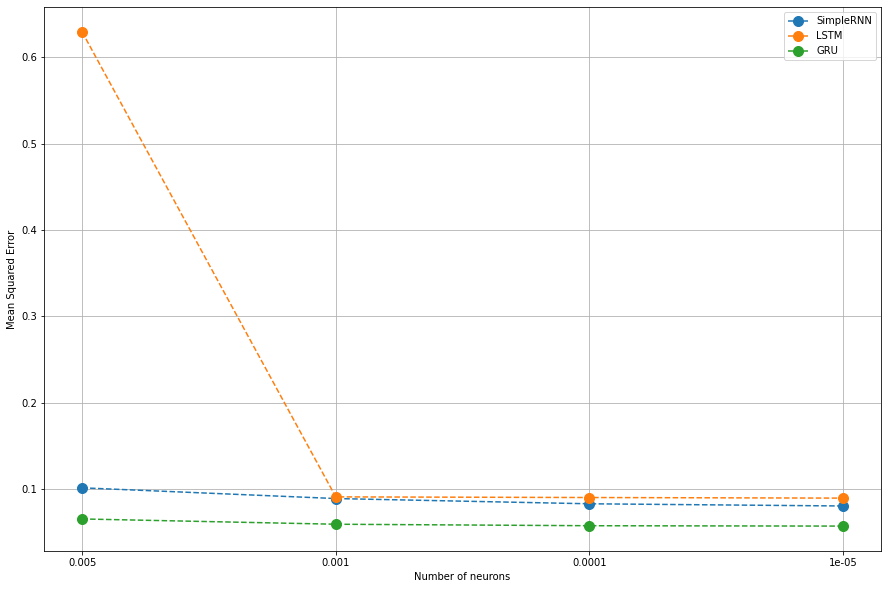

In [8]:
plt.figure(figsize=(15,10))
plt.plot(mse_list_lr[0], '.--', markersize=20, label="SimpleRNN")
plt.plot(mse_list_lr[1], '.--', markersize=20, label="LSTM")
plt.plot(mse_list_lr[2], '.--', markersize=20, label="GRU")
plt.xticks(ticks = np.arange(4), labels=learningrates)
plt.xlabel(f"Number of neurons")
plt.ylabel(f"Mean Squared Error")
plt.grid()
plt.legend()
plt.savefig(f"../figures/multivariate_forecast_lr_grid_search.pdf")